## Importing necessry libraries and modules

In [1]:
%pip install wordcloud
%pip install seaborn
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

unable to import 'smart_open.gcs', disabling that module
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading in data 

In [3]:
data = pd.read_csv('articles.csv', error_bad_lines=False, nrows=50)

In [4]:
data.head()

,Unnamed: 0,abstract,body,paper_id,abstract_word_count,body_word_count
0,0,word count text word count authorfunder ...,vp and vp which is further processed to vp and...,0015023cc06b5362d332b3baf348d11567ca2fbb,241,1728
1,1,during the past three months a new coronavirus...,in december a novel coronavirus sarscov was i...,00340eea543336d54adda18236424de6a5e91c9d,175,2549
2,2,NaN,the ncov epidemic has spread across china and ...,004f0f8bb66cf446678dc13cf2701feec4f36d76,0,755
3,3,the fast accumulation of viral metagenomic dat...,metagenomic sequencing which allows us to dire...,00911cf4f99a3d5ae5e5b787675646a743574496,139,5188
4,4,infectious bronchitis ib causes significant ec...,infectious bronchitis ib which is caused by in...,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,1647,4003


In [5]:
# Making a new dataframe with the column i need and delete NAN values of abstracts
abstracts = data[['abstract']]
abstracts = abstracts.dropna()
documents = abstracts

## Data preprocessing
1. Tokenization/lemmatization/lowercase
2. Stopwords removed 
3. Remove punctuation

In [6]:
def lemmatizer(word,pos): 
    '''
        the lemmatizer takes the 'word' and based on the 'pos' finds the base word of the 'word'
        the pos defines weather to look for a verb, noun, etc. 
    '''
    lem = WordNetLemmatizer()
    return lem.lemmatize(word, pos=pos)

def wordStemmer(word): 
    '''
        the wordstemmer, returns the stem of the word 'word'
    '''
    stemmer = SnowballStemmer('english')
    wordstem = stemmer.stem(word)
    return wordstem

def textpreprocessing(text):
    '''
        takes in a 'text',tokenize it, remove stopwords, lemmatize, and finds the stem of each word. 
        Returns the preprocessed text
    '''
    result = []
    for token in word_tokenize(text):
        if token not in set(stopwords.words('english')):
            txt = lemmatizer(token, 'v')
            txt = wordStemmer(txt)
            result.append(txt)
    return result
    

In [21]:
documents

,abstract
0,word count text word count authorfunder ...
1,during the past three months a new coronavirus...
3,the fast accumulation of viral metagenomic dat...
4,infectious bronchitis ib causes significant ec...
5,nipah virus niv came into limelight recently d...
6,background a novel coronavirus ncov emerged in...
7,all rights reserved no reuse allowed without p...
8,faced with the current largescale public healt...
9,viruses interact with hundreds to thousands of...
10,school closure is often considered as an optio...


In [10]:
# preprocess all the abstracts
processed_abstracts = documents['abstract'].map(textpreprocessing)

In [11]:
processed_abstracts

0     [word, count, text, word, count, authorfund, r...
1     [past, three, month, new, coronavirus, sarscov...
3     [fast, accumul, viral, metagenom, data, contri...
4     [infecti, bronchiti, ib, caus, signific, econo...
5     [nipah, virus, niv, come, limelight, recent, d...
6     [background, novel, coronavirus, ncov, emerg, ...
7     [right, reserv, reus, allow, without, permiss,...
8     [face, current, largescal, public, health, eme...
9     [virus, interact, hundr, thousand, protein, ma...
10    [school, closur, often, consid, option, mitig,...
11    [posttranscript, gene, silenc, ptgs, power, to...
13    [object, review, critic, apprais, publish, pre...
14    [human, astrovirus, small, nonenvelop, virus, ...
15    [ribosom, frameshift, translat, rna, implic, h...
16    [recent, outbreak, infect, novel, coronavirus,...
17    [note, logist, growth, regress, model, use, es...
19    [paper, evalu, total, inclus, cost, three, pub...
21    [outbreak, novel, coronavirus, name, covid

In [12]:
# In this dictionary we save all the tokens in the processed_abstracts
# The dictionary saves an ID for each token/word from the docs
dictionary = gensim.corpora.Dictionary(processed_abstracts)

In [13]:
abstract_bow = [dictionary.doc2bow(doc) for doc in processed_abstracts]

note: 
coronavirus related words
-virus
-viral 
-coronavirus
-respiratori
-pneumonia
-lungs
-outbreak
-pandem


## Visualize token frequenxy 

In [14]:
# Put together all tokens from all abstracts in a single list
abstract_tokens = []
for i in processed_abstracts:
    for j in i:
        abstract_tokens.append(j)


# Using countvectorizer to vectorize the abstract tokens, as it counts the term frequency 
vectorizer = CountVectorizer(stop_words='english')
vectorizer_data = vectorizer.fit_transform(abstract_tokens)

feature_names = vectorizer.get_feature_names()
counts = np.zeros(len(feature_names))
for i in vectorizer_data:
    counts+= i.toarray()[0]
    

sorted_dict = sorted((zip(feature_names, counts)), key=lambda x:x[1], reverse=True)[0:25]
words = [w[0] for w in sorted_dict]
word_counts = [w[1] for w in sorted_dict]
x_pos = np.arange(len(words)) 

# The plot shows the most frequent words used in all the abstracts
#plt.figure(2, figsize=(15, 7))
#sns.barplot(x_pos, word_counts, palette='hls')
#plt.xticks(x_pos, words, rotation=90) 
#plt.show()

## WordCloud

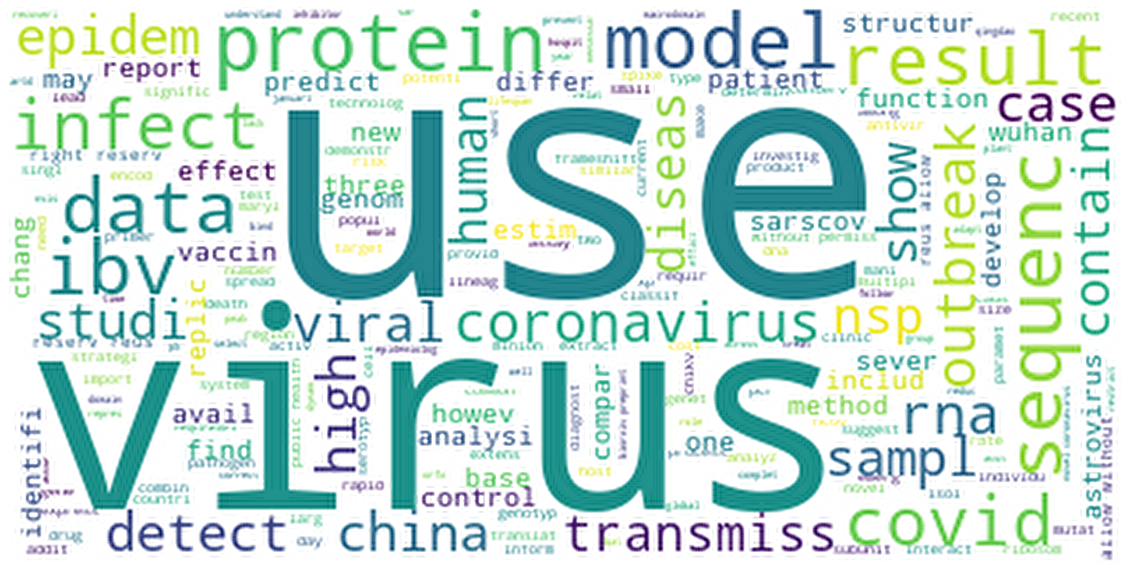

In [19]:
# Convert the whole collection to a single string to use in the wordcloud
# can make this later for each cluster if we want
docs = pd.DataFrame(processed_abstracts)
allabstracts = ""
for i in processed_abstracts:
    for j in i:
        allabstracts += j
        allabstracts += ' '

    
wordcloud = WordCloud(background_color="white", max_words=200)
wordcloud.generate(allabstracts)
wordcloud.to_image()

import matplotlib.pyplot as plt
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="sinc")
plt.axis("off")
plt.show()

## LDA - topic modelling

In [16]:
from gensim.models import TfidfModel
# First fit the dict abstract_bow using the tfidfmodel 
tfidf_model = TfidfModel(abstract_bow)

# now apply the tfidf_model to the documents
corpus_tfidf = tfidf_model[abstract_bow]   # can here just try to apply to the first doc in corpus to see results

In [17]:
lda_model = gensim.models.LdaMulticore(abstract_bow, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [18]:
# Shows 10 topics extracted from the abstracts

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {}      Word:  {}'.format(idx, topic) + "\n")

Topic: 0      Word:  0.004*"morbid" + 0.003*"sirna" + 0.003*"protein" + 0.003*"peak" + 0.003*"nsp" + 0.003*"deliveri" + 0.003*"vaccin" + 0.003*"filter" + 0.003*"plant" + 0.003*"cohort"

Topic: 1      Word:  0.006*"frameshift" + 0.003*"translat" + 0.002*"rna" + 0.002*"live" + 0.002*"singl" + 0.001*"kinet" + 0.001*"ribosom" + 0.001*"technolog" + 0.001*"retrovir" + 0.001*"jam"

Topic: 2      Word:  0.003*"januari" + 0.002*"wuhan" + 0.002*"confirm" + 0.002*"lockdown" + 0.002*"mainland" + 0.002*"nationwid" + 0.002*"nonwuhan" + 0.002*"home" + 0.002*"case" + 0.002*"movement"

Topic: 3      Word:  0.004*"travel" + 0.003*"citi" + 0.003*"restrict" + 0.003*"end" + 0.003*"background" + 0.003*"covid" + 0.003*"china" + 0.003*"nvis" + 0.003*"humantohuman" + 0.003*"social"

Topic: 4      Word:  0.004*"r" + 0.003*"secondari" + 0.002*"number" + 0.002*"heterogen" + 0.002*"moment" + 0.002*"pathogen" + 0.002*"size" + 0.002*"emerg" + 0.002*"outbreak" + 0.002*"contact"

Topic: 5      Word:  0.002*"apprais" +